## Fetal Immune Atlas - experimental design plots 


In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [5]:
new_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv'.format(t=timestamp))

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Dataset stats

For manuscript

In [126]:
# def save_dataset_stats(new_obs, timestamp, data_dir="/nfs/team205/ed6/data/Fetal_immune/"):
dataset_stats = {}
dataset_stats['n_cells'] = new_obs.shape[0]
n_annotated_cells = new_obs[~new_obs.uniform_label.isna()].shape[0]
dataset_stats['perc_annotated_cells'] = n_annotated_cells/dataset_stats['n_cells']
dataset_stats['n_samples'] = new_obs.Sample.unique().shape[0]
dataset_stats['n_donors'] = new_obs.donor.unique().shape[0]
print(dataset_stats)

{'n_cells': 911873, 'perc_annotated_cells': 0.6645947407149899, 'n_samples': 221, 'n_donors': 25}


### Plot pre-existing annotations

In [6]:
df = new_obs[['uniform_label_lvl0', "uniform_label_expanded_merged","Sample", 'organ']].groupby(["uniform_label_lvl0","uniform_label_expanded_merged","organ"]).count() \
    .unstack(fill_value=0).stack().reset_index()

'organ'

In [7]:
%%R -i df -w 1000 -h 1300
library(patchwork)

p1 <- df %>% 
rename(count=Sample) %>%
ggplot(aes(uniform_label_expanded_merged, count, fill=organ)) +
geom_col(position="fill") +
# scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
ylab("fraction") +
theme(strip.background = element_blank(),
  strip.text.y = element_blank()) 

p2 <- df %>%
rename(count=Sample) %>%
group_by(uniform_label_expanded_merged, uniform_label_lvl0) %>%
summarise(tot_count=sum(count)) %>%
ggplot(aes(uniform_label_expanded_merged, tot_count)) +
geom_col() +
scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
theme(strip.text.y=element_text(angle=0), axis.text.y=element_blank(),
     axis.ticks.y=element_blank(), axis.title.y=element_blank()) 

`summarise()` has grouped output by 'uniform_label_expanded_merged'. You can override using the `.groups` argument.


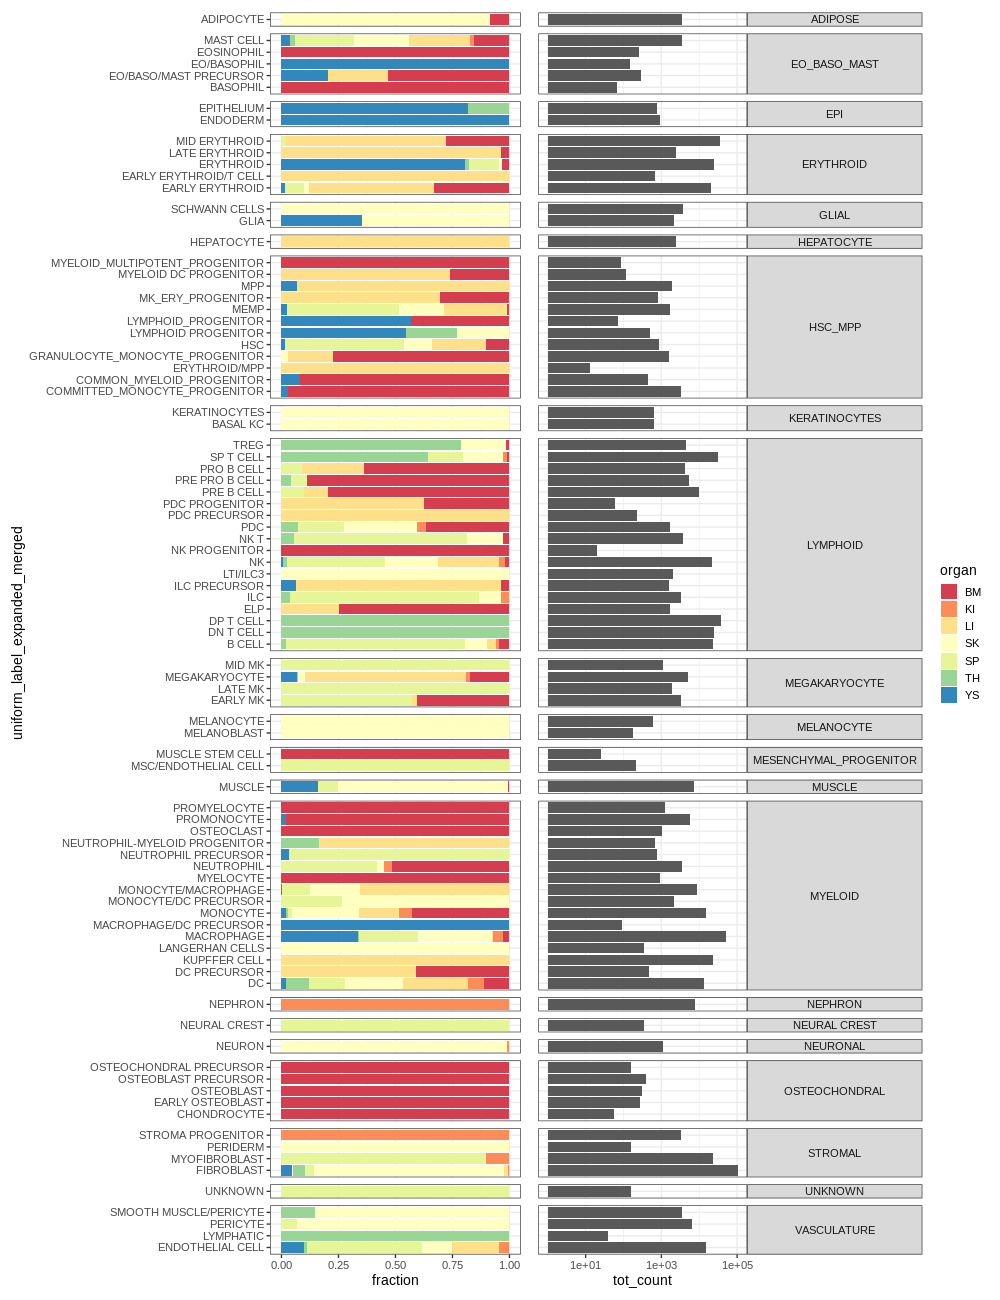

In [8]:
%%R -w 1000 -h 1300
p1 + p2 +
plot_layout(guides="collect", widths=c(1.2,1)) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.pdf", width=14, height=16) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.png", width=14, height=16)

### Plot donor VS organs

In [76]:
donor_count = new_obs.reset_index()[["organ", "donor", "index"]].groupby(["donor", "organ"]).count().reset_index()


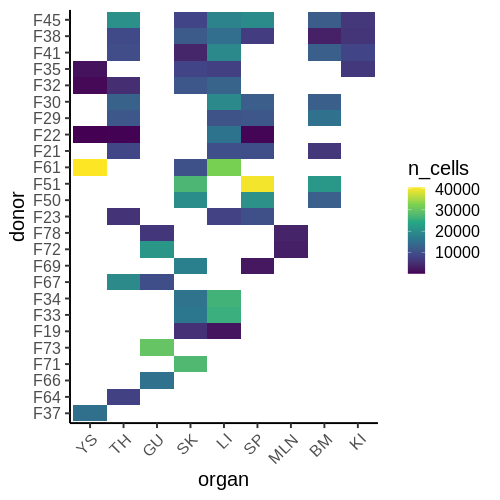

In [11]:
%%R -i donor_count -w 500 -h 500

donor_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(organ, donor, fill=n_cells)) +
geom_tile() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
scale_fill_viridis_c() +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.pdf", width=7, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.png", width=7, height=8)

In [83]:
method_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index", "method"]].groupby(["Sample", "donor", "organ", 'age', 'method']).count().reset_index()


In [84]:
method_count

,Sample,donor,organ,age,method,index
0,F19_LI_CD45N_FCAImmP7241243,F19,LI,10,3GEX,147
1,F19_LI_CD45P_FCAImmP7241242,F19,LI,10,3GEX,1719
2,F19_SK_CD45N_FCAImmP7241241,F19,SK,10,3GEX,5076
3,F19_SK_CD45P_FCAImmP7241240,F19,SK,10,3GEX,379
4,F21_BM_CD45N_FCAImmP7179368,F21,BM,16,3GEX,2383
...,...,...,...,...,...,...
216,F78_GU_CD45P_CD45N_FCA_gut8015057,F78,GU,17,5GEX,777
217,F78_GU_CD45P_CD45N_FCA_gut8015058,F78,GU,17,5GEX,1854
218,F78_GU_CD45P_CD45N_FCA_gut8015059,F78,GU,17,5GEX,1552
219,F78_GU_CD45P_CD45N_FCA_gut8015060,F78,GU,17,5GEX,1918


In [103]:
import numpy as np
import matplotlib.pyplot as plt


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

method_colors = colors[:2]
method_colors

['#1f77b4', '#ff7f0e']

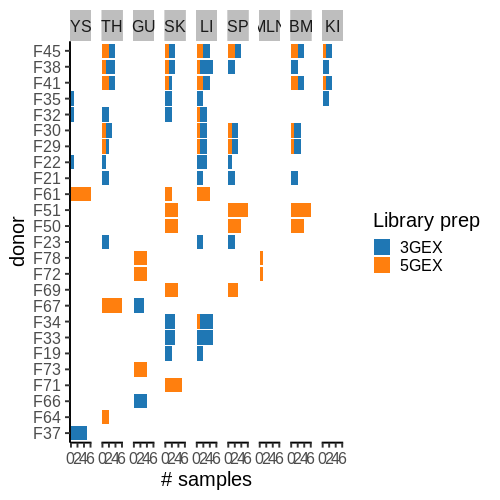

In [107]:
%%R -i method_count -i method_colors -w 500 -h 500

method_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=length(unique(organ)), n_samples=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, fill=method)) +
geom_bar() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
facet_grid(.~organ) +
    theme_classic(base_size=20) +
    scale_color_brewer(palette="Spectral") +
    guides(color="none") +
    scale_size(range=c(5,10), name="# cells") +
    coord_flip() +
    ylab("# samples") +
    scale_fill_manual(name="Library prep", values=method_colors) +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
#         axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
    ) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_method_plot.pdf", width=10, height=6) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_method_plot.png", width=10, height=6)

### Plot organ VS age

In [108]:
age_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index", "method"]].groupby(["Sample", "donor", "organ", 'age', 'method']).count().reset_index()


`summarise()` has grouped output by 'organ', 'age'. You can override using the `.groups` argument.


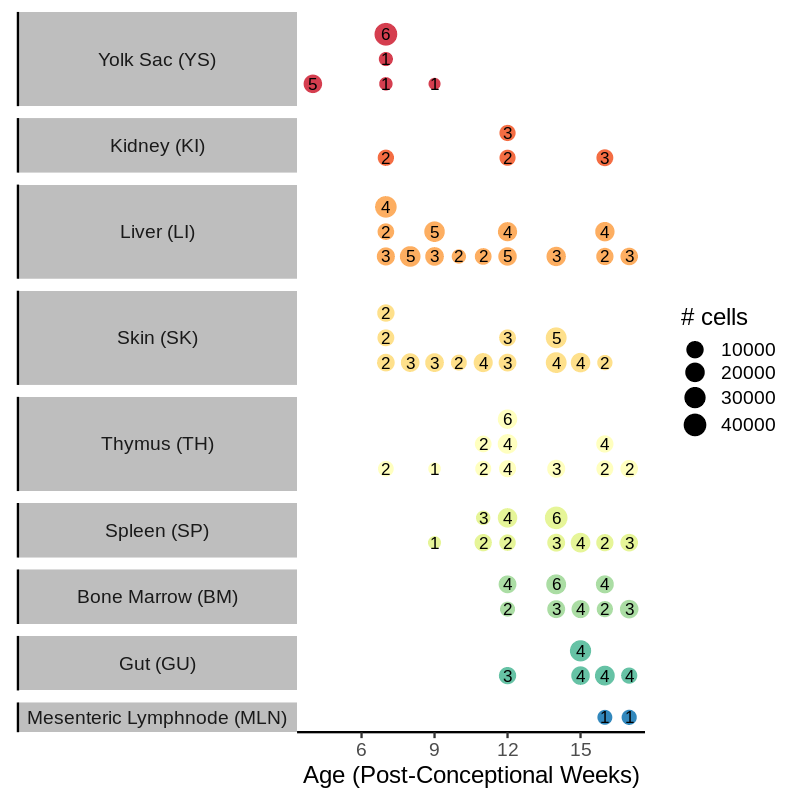

In [109]:
%%R -i age_count -w 800 -h 800

organ_labeller <- c(
    BM="Bone Marrow (BM)",
    GU="Gut (GU)",
    KI="Kidney (KI)",
    LI="Liver (LI)",
    MLN="Mesenteric Lymphnode (MLN)",
    SK="Skin (SK)",
    SP="Spleen (SP)",
    TH="Thymus (TH)",
    YS="Yolk Sac (YS)"
)

pl <- age_count %>%
    rename(n_cells=index) %>%
    arrange(age, donor, organ) %>%
    mutate(donor = factor(donor, levels=unique(donor))) %>%
    mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
    # mutate(organ = factor(organ, levels=unique(organ))) %>%
    group_by(organ, age, donor) %>%
    summarise(n_samples=n(), n_cells=sum(n_cells)) %>%
    group_by(organ, age) %>%
    mutate(rank_donor=row_number()) %>%
    mutate(organ=organ_labeller[organ]) %>%
    group_by(organ) %>%
    mutate(min_age=min(age)) %>%
    ungroup() %>%
    arrange(min_age) %>%
    mutate(organ=factor(organ, levels=unique(organ))) %>%
    ggplot(aes(age, rank_donor, color=organ)) +
    geom_point(aes(size=n_cells)) +
    geom_text(aes(label=n_samples), color="black", size=6) +
    # geom_tile(color='black') +
    scale_y_continuous(expand=c(0.3,0.3)) +
    xlab("Age (Post-Conceptional Weeks)") +
    theme_classic(base_size=24) +
    scale_color_brewer(palette="Spectral") +
    guides(color="none") +
    facet_grid(organ~., scales="free", space="free", switch="both") +
    scale_size(range=c(5,10), name="# cells") +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()
    ) 



pl +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.pdf", width=12, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.png", width=12, height=8) 





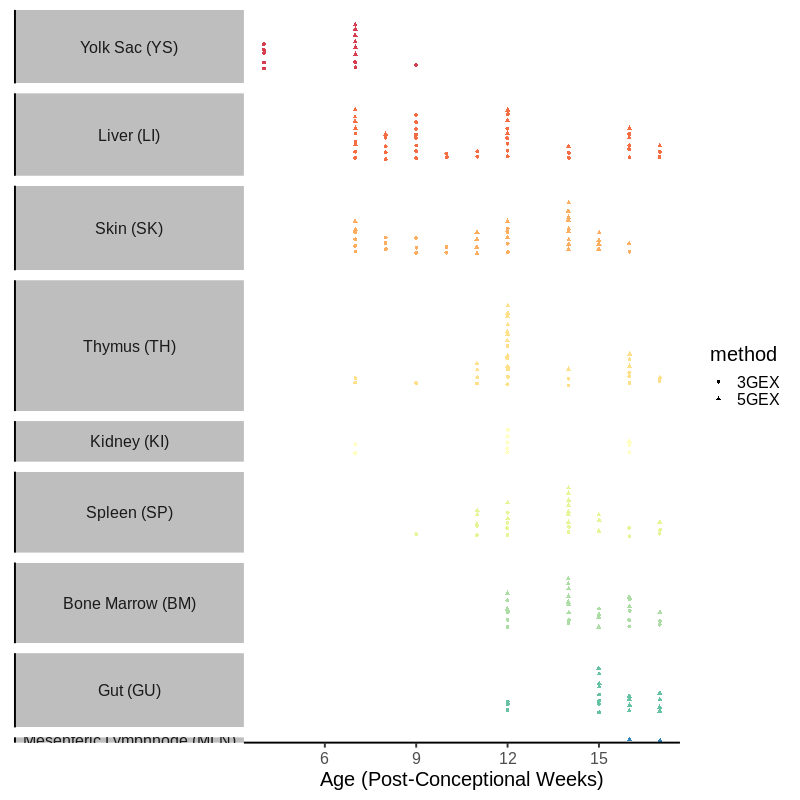

In [72]:
%%R -i age_count -w 800 -h 800

organ_labeller <- c(
    BM="Bone Marrow (BM)",
    GU="Gut (GU)",
    KI="Kidney (KI)",
    LI="Liver (LI)",
    MLN="Mesenteric Lymphnode (MLN)",
    SK="Skin (SK)",
    SP="Spleen (SP)",
    TH="Thymus (TH)",
    YS="Yolk Sac (YS)"
)

pl <- age_count %>%
    rename(n_cells=index) %>%
    arrange(age, donor, organ) %>%
    mutate(donor = factor(donor, levels=unique(donor))) %>%
    mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
    # mutate(organ = factor(organ, levels=unique(organ))) %>%
#     group_by(organ, age, donor) %>%
#     summarise(n_samples=n(), n_cells=sum(n_cells)) %>%
    group_by(organ, age) %>%
    mutate(rank_donor=row_number()) %>%
    mutate(organ=organ_labeller[organ]) %>%
    group_by(organ) %>%
    mutate(min_age=min(age)) %>%
    ungroup() %>%
    arrange(min_age) %>%
    mutate(organ=factor(organ, levels=unique(organ))) %>%
    ggplot(aes(age, rank_donor, color=organ, shape=method)) +
    geom_jitter(width=0.01) +
    # geom_point(aes(size=n_cells)) +
    # geom_text(aes(label=n_samples), color="black", size=6) +
    # geom_tile(color='black') +
    scale_y_continuous(expand=c(0.3,0.3)) +
    xlab("Age (Post-Conceptional Weeks)") +
    theme_classic(base_size=20) +
    scale_color_brewer(palette="Spectral") +
    guides(color="none") +
    facet_grid(organ~., scales="free", space="free", switch="both") +
    scale_size(range=c(5,10), name="# cells") +
    theme(
        strip.text.y.left = element_text(angle=0),
        strip.background = element_rect(fill="grey", color=NA),
        axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank()
    ) 



# pl +
# ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.pdf", width=12, height=8) +
# ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/ageVSorgan_plot.png", width=12, height=8) 


pl


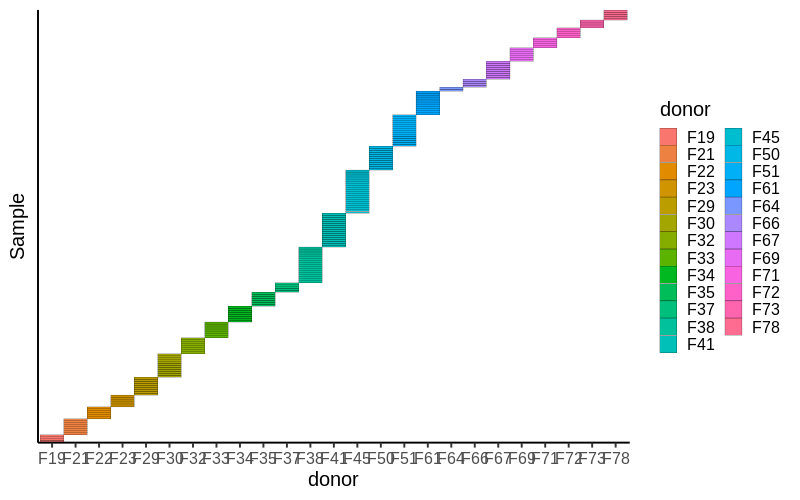

In [99]:
%%R -i age_count -w 800 -h 500

age_count %>%
rename(n_cells=index) %>%
arrange(donor, organ) %>%
# mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, Sample, fill=donor)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())  
